<a href="https://colab.research.google.com/github/FirangizSadiyeva/Covid-19/blob/main/Covid19_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
country = "Azerbaijan"


In [9]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#df_confirmed.to_csv('global.csv')
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

In [10]:
df_confirmed 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400,53489,53538,53584,53584,53775,53831,53938,53984,54062,54141,54278,54403,54483,54559,54595,54672,54750,54854
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033,63595,63971,64627,65334,65994,66635,67216,67690,67982,68568,69238,69916,70655,71441,72274,72812,73691,74567
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913,102144,102369,102641,102860,103127,103381,103611,103833,104092,104341,104606,104852,105124,105369,105596,105854,106097,106359
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586,8586,8586,8682,8818,8868,8946,9038,9083,9083,9194,9308,9379,9416,9499,9549,9596,9638,9716
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156,18193,18254,18343,18425,18613,18679,18765,18875,18926,19011,19093,19177,19269,19367,19399,19476,19553,19580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,1411,1413,1414,1420,1421,1432,1439,1440,1441,1451,1454,1456,1465,1474,1482,1494,1497,1504,1505,1509,1512,1513,1514,1515,1520,1521,1531,1536,1537,1537,1539,1540,1544,1546,1548,1548,1548,1549,1551,1553
269,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,121216,122643,123945,125506,127376,129080,130598,131904,133093,134310,135459,136736,138004,139223,140287,141219,142228,143169,144257,145252,146074,146701,147400,148171,148968,149769,150505,151142,151569,152031,152555,153093,153590,154063,154557,155006,155414,155884,156393,156996
270,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2087,2087,2087,2087,2087,2092,2092,2092,2094,2096,2096,2097,2099,2101,2101,2101,2101,2101,2102,2104,2104,2104,2104,2105,2107,2109,2110,2111,2112,2112,2113,2115,2115,2115,2118,2118,2118,2118,2119,2120
271,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18620,18716,18768,18881,19122,19234,19571,19671,19834,19943,20177,20462,20725,20997,21230,21582,21993,22645,23495,24297,25326,26

Total days in the dataset 372


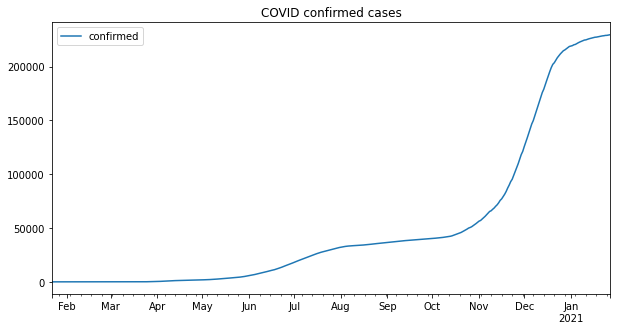

In [11]:
df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

df_confirmed_country.tail(10)

print("Total days in the dataset", len(df_confirmed_country))

In [12]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

In [13]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [14]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

Total number of samples in the original training data =  358
Total number of samples in the generated data =  351


In [16]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

In [17]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

In [19]:
#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 150)            91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...


In [20]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=50, steps_per_epoch=10)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
10/10 [==============================] - 3s 54ms/step - loss: 0.1366 - val_loss: 0.7095
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1722 - val_loss: 0.4282
Epoch 3/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0438 - val_loss: 0.3151
Epoch 4/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0820 - val_loss: 0.0174
Epoch 5/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0105 - val_loss: 0.0750
Epoch 6/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0983
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0257 - val_loss: 0.0752
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 9/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 5.7298e-04
Epoch 10/50
10/10 [==============================] - 0s 14ms/step - loss: 8.2290e-04 - val_loss: 0.0028
E

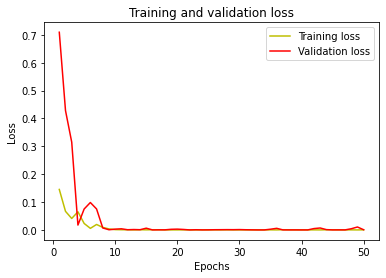

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [22]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

In [23]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [24]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data


In [25]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [26]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

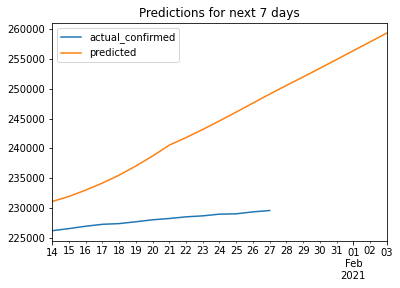

In [27]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")
